# Predictive Modelling

Predictive Modelling can be proceduralized as follows;

1. <a href='#model_building_and_predicting_section'><b>Model Building And Clustering</b></a>
    - 1.1. <a href='#kmeans_section'><b>K-Means</b></a>
    - 1.2. <a href='#dbscan_section'><b>Density-Based Spatial Clustering of Applications with Noise(DBSCAN)</b></a>
    - 1.3. <a href='#gmm_section'><b>Gussian Mixture Models(GMM)</b></a>
2. <a href='#model_evaluation_section'><b>Model Evaluation</b></a>
    - 2.1. <a href='#statistical_evaluation_section'><b>Statistical Evaluation</b></a>
    - 2.2. <a href='#visual_evaluation_section'><b>Visual Evaluation</b></a>
3. <a href='#conclusion_section'><b>Conclusion</b></a>

---

## Data Read

In [1]:
# Import necessary libraries for data obtaining
import pandas as pd

In [2]:
# Read the data into a data frame
transformed_data = pd.read_csv('Transformed_Data_Robust.csv')

In [3]:
transformed_data.head()

AT        AP        AH      AFDP      GTEP       TIT       TAT  \
0 -1.135397  0.765432  0.148050 -0.359420 -0.197666  0.008197 -0.010331   
1 -1.160387  0.716049  0.174488 -0.364255 -0.202543  0.004098  0.035124   
2 -1.193358  0.728395  0.203900 -0.352512 -0.195751  0.020492  0.064050   
3 -1.207007  0.716049  0.231092 -0.354485 -0.209509  0.020492  0.059917   
4 -1.206328  0.654321  0.219196 -0.357150 -0.208464 -0.004098  0.024793   

        TEY       CDP        CO       NOX  
0  0.049839 -0.051225 -0.857622  1.275130  
1  0.049839 -0.055679 -0.782238  1.304921  
2  0.072883  0.055679 -0.779999  1.402986  
3  0.069132  0.017075 -0.917053  1.313893  
4  0.049839 -0.042316 -0.894415  1.280457

In [4]:
print(transformed_data.shape)
print('!!! Dataset is reduced to a smaller portion of itself due to heavy computational reasons')
transformed_data = transformed_data.loc[:22191, :]
print(transformed_data.shape)

(35917, 11)
!!! Dataset is reduced to a smaller portion of itself due to heavy computational reasons
(22192, 11)


---

<a id='model_building_and_predicting_section'></a>
## 1. Model Building And Clustering

There are 3 methods that are used to cluster customers.<br>
Also, the number of clusters is determined as 4 as default. Because, the simplest assumption should be 4 types of cluster such as desired customer, neutral customer and undesired customer.

In [5]:
predictions = pd.DataFrame()

<a id='kmeans_section'></a>
### 1.1. K-Means

In the K-Means algorithm, the number of clusters needs to be specified. However, the best number of clusters can be found by using the KElbowVisualizer method.

In [7]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [8]:
transformed_data.head()

AT        AP        AH      AFDP      GTEP       TIT       TAT  \
0 -1.135397  0.765432  0.148050 -0.359420 -0.197666  0.008197 -0.010331   
1 -1.160387  0.716049  0.174488 -0.364255 -0.202543  0.004098  0.035124   
2 -1.193358  0.728395  0.203900 -0.352512 -0.195751  0.020492  0.064050   
3 -1.207007  0.716049  0.231092 -0.354485 -0.209509  0.020492  0.059917   
4 -1.206328  0.654321  0.219196 -0.357150 -0.208464 -0.004098  0.024793   

        TEY       CDP        CO       NOX  
0  0.049839 -0.051225 -0.857622  1.275130  
1  0.049839 -0.055679 -0.782238  1.304921  
2  0.072883  0.055679 -0.779999  1.402986  
3  0.069132  0.017075 -0.917053  1.313893  
4  0.049839 -0.042316 -0.894415  1.280457

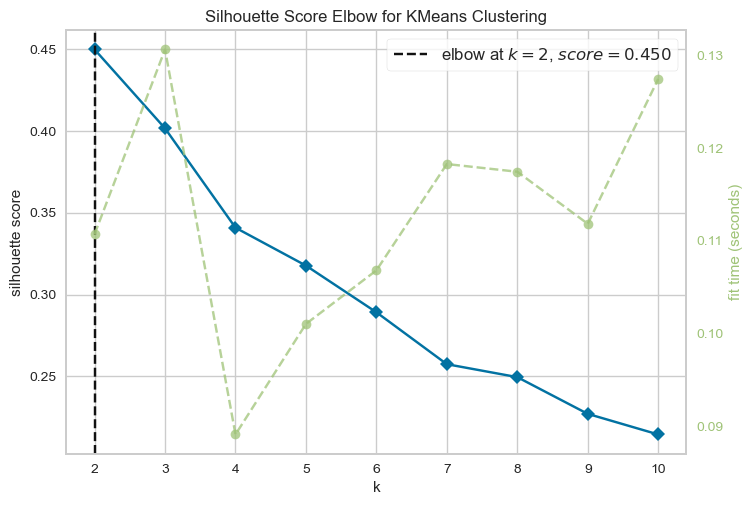

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [10]:
# In order to understand best performed cluster number K-Elbow Method is used
kelbow_visualizer = KElbowVisualizer(KMeans(n_init='auto'), k=(2,11), metric='silhouette')
kelbow_visualizer.fit(transformed_data)
kelbow_visualizer.show()

The KElbowVisualizer suggests the number of clusters to be 2 with respect to above graph. However, it is assumed as 3. Since, 2 clusters might be insufficient and the following best silhouette score in the above graph belongs to k=3 clusters.

**!!!** It must be mentioned that KMeans model starts randomly selected centroids for the clusters and this chaotic/random structure of the model might leads to a different cluster numbers that is represented above graph. 

---

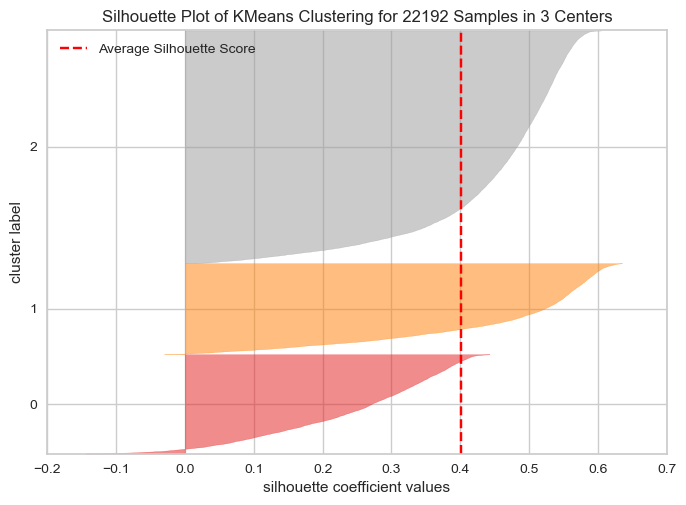

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 22192 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [11]:
silhouette_visualizer = SilhouetteVisualizer(KMeans(n_clusters=3, n_init='auto'))
silhouette_visualizer.fit(transformed_data)
silhouette_visualizer.show()

As the **Elbow Method** suggests, number of the clusters should be 3 for the best segmentation. However, the **silhouette** metric is used in the KElbowVisualizer function but there are two different metrics too. The silhouette metric calculates mean of the silhouette score and *silhouette score* states that where the data is located. If the silhouette score is close to +1, then the data point is well clustered. If the silhouette score is close to 0, then the data point is at the clusters' boundaries and it might be misclustered. If the silhouette score is close to -1, then the data point is poorly clustered.

---

In [8]:
# model is defined and cluster predictions are obtained
kmeans = KMeans(n_clusters=3, n_init='auto')
k_means_y_hat = kmeans.fit_predict(transformed_data)

In [9]:
# obtained predictions are assigned to a new column in the transform data
predictions['KMeans_Cluster'] = k_means_y_hat

<a id='dbscan_section'></a>
### 1.2. Density-Based Spatial Clustering of Applications with Noise(DBSCAN)

In the DBSCAN algorithm, there are two extremely important variables as **Epsilon** and **Minimum Samples**.<br>
- **eps**: Epsilon ---> Radius of a data point
- **min_samples**: Minimum Samples ---> minimum number of data points that can be in the data point circle with epsilon radius

**Epsilon** can be determined by using maximum curvature of the **K-Distance Graph** and K-Distance graph is formed by using distance values that come from NearestNeighbors algorithm.<br>
**Minimum Samples** are generally determined as **2**x**Dimensions**. However, it can be determined as the domain knowledge suggested.<br>
<br>
One of the advantages of the DBSCAN model is the noise determination. After clustering, the model returns one extra cluster as **-1** that represents **noise**.

In [10]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# distance determination between each two data points
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fitted = neighbors.fit(transformed_data)
distances, indices = neighbors_fitted.kneighbors(transformed_data)

Text(0.5, 1.0, 'K-Distance Graph For Online Retail Dataset')

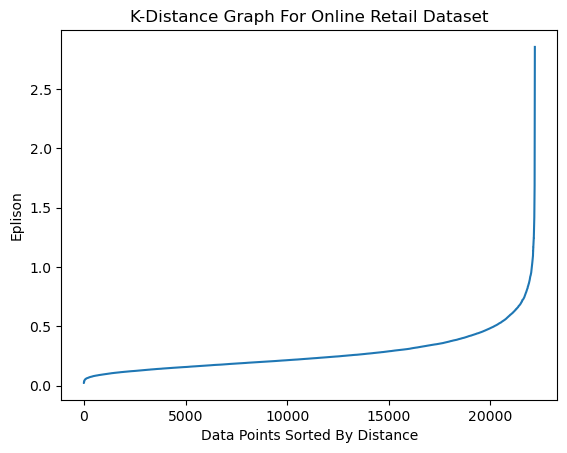

In [12]:
# K-Distance Graph
distances = np.sort(distances, axis=0)[:,1]
plt.plot(distances)
plt.xlabel('Data Points Sorted By Distance')
plt.ylabel('Eplison')
plt.title('K-Distance Graph For Online Retail Dataset')

According to the K-Distance Graph, maximum curvature should be around 0.5. Therefore, Epsilon is assumed as **eps=0.7**.\
Minimum sample is determined as **min_samples = 2\*(Number of Features)** ---> min_samples = 2*11 = 22

In [13]:
# model is defined and cluster predictions are obtained
dbscan = DBSCAN(eps=0.7, min_samples=22)
dbscan.fit(transformed_data)

DBSCAN(eps=0.7, min_samples=22)

In [14]:
# obtained predictions are assigned to a new column in the transform data
predictions['DBSCAN_Cluster'] = dbscan.labels_

In [15]:
# all clusters and their counts with NOISE
predictions['DBSCAN_Cluster'].value_counts()

 0    18701
-1     3382
 2       44
 1       37
 3       28
Name: DBSCAN_Cluster, dtype: int64

<a id='gmm_section'></a>
### 1.3. Gussian Mixture Models(GMM)

In [16]:
from sklearn.mixture import GaussianMixture

In [17]:
gmm = GaussianMixture(n_components=3)
gmm_y_hat = gmm.fit_predict(transformed_data)

In [18]:
# obtained predictions are assigned to a new column in the transform data
predictions['GMM_Cluster'] = gmm_y_hat

---

In [19]:
print('\nK-Means\n', predictions.KMeans_Cluster.value_counts())
print('\nDBSCAN\n',predictions.DBSCAN_Cluster.value_counts())
print('\nGMM\n',predictions.GMM_Cluster.value_counts())


K-Means
 0    12205
2     5216
1     4771
Name: KMeans_Cluster, dtype: int64

DBSCAN
  0    18701
-1     3382
 2       44
 1       37
 3       28
Name: DBSCAN_Cluster, dtype: int64

GMM
 0    9758
1    7813
2    4621
Name: GMM_Cluster, dtype: int64


<a id='model_evaluation_section'></a>
## 2. Model Evaluation

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

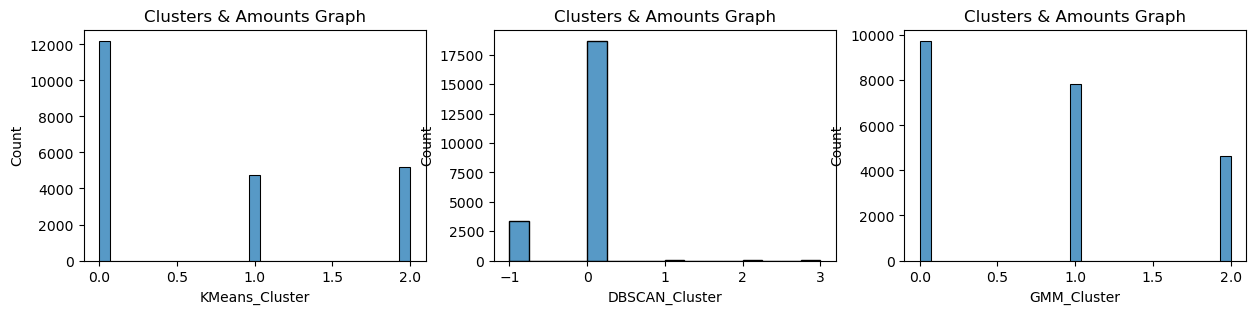

In [21]:
plt.figure(figsize=(15,3))
for i,j in enumerate(predictions):
    plt.subplot(1,3, i+1)
    ax = sns.histplot(predictions[j])
    ax.set(title='Clusters & Amounts Graph')

As it can be seen above graphs, each model performed differently. Especially, DBSCAN model generated more than default number of clusters.

---

<a id='statistical_evaluation_section'></a>
### 2.1. Statistical Evaluation

In the statistical evaluation section, there are 3 metric is used to evaluate model results. In this project only **Internal Validation** methods are used and *External Validation* metrics couldn't be used due to absence of pre-determined labels. Used *internal validation* metrics are as follows;
**Silhouette Score**, **Davies-Bouldin Index** and **Calinski-Harabasz Index**. 

---

#### Silhouette Scores

In the Silhouette Scores, results vary between -1 and +1.

**-1** represents the data points might be *mis-clustered*, **0** represents the data points might be at the bounday of the clusters which leads to mis-clustering. **+1** represents the data points might be well clustered.

In [22]:
from sklearn.metrics import silhouette_score

In [23]:
kmeans_ss = silhouette_score(transformed_data, predictions.KMeans_Cluster)
dbscan_ss = silhouette_score(transformed_data, predictions.DBSCAN_Cluster)
gmm_ss = silhouette_score(transformed_data, predictions.GMM_Cluster)

Text(0.5, 1.0, 'Silhouette Scores Of The Models')

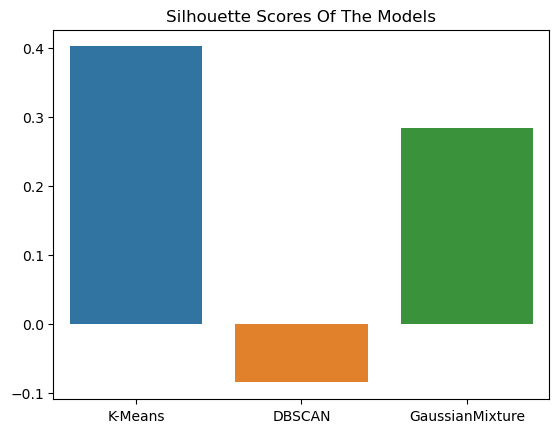

In [24]:
ss_df = pd.DataFrame(data={'K-Means':kmeans_ss, 'DBSCAN':dbscan_ss, 'GaussianMixture':gmm_ss}, index=[0])
sns.barplot(ss_df)
plt.title('Silhouette Scores Of The Models')

As the above plot shows the best result comes from K-Means algorithm due to having of highest positive result.

#### Davies-Bouldin Index

This index will result in better result if the dataset clusters are all separated. And higher value represent worse results and lower results are desired scores.

In [25]:
from sklearn.metrics import davies_bouldin_score

In [26]:
kmeans_dbi = davies_bouldin_score(transformed_data, predictions.KMeans_Cluster)
dbscan_dbi = davies_bouldin_score(transformed_data, predictions.DBSCAN_Cluster)
gmm_dbi = davies_bouldin_score(transformed_data, predictions.GMM_Cluster)

Text(0.5, 1.0, 'Davies-Bouldin Indexes Of The Models')

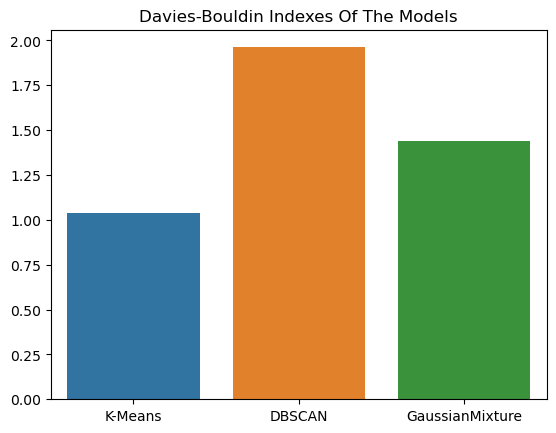

In [27]:
dbi_df = pd.DataFrame(data={'K-Means':kmeans_dbi, 'DBSCAN':dbscan_dbi, 'GaussianMixture':gmm_dbi}, index=[0])
sns.barplot(dbi_df)
plt.title('Davies-Bouldin Indexes Of The Models')

As the above plot shows the best result comes from K-Means algorithm due to having of lowest result.

#### Calinski-Harabasz Index

Well separated and dense clustered models will result in higher value of score. However, there is no limitation or cut off edge for wellness determination of the clusters.

In [28]:
from sklearn.metrics import calinski_harabasz_score

In [29]:
kmeans_chi = calinski_harabasz_score(transformed_data, predictions.KMeans_Cluster)
dbscan_chi = calinski_harabasz_score(transformed_data, predictions.DBSCAN_Cluster)
gmm_chi = calinski_harabasz_score(transformed_data, predictions.GMM_Cluster)

Text(0.5, 1.0, 'Calinski-Harabasz Indexes Of The Models')

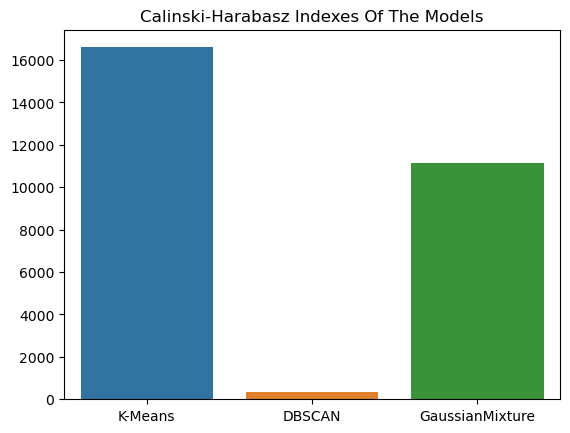

In [30]:
chi_df = pd.DataFrame(data={'K-Means':kmeans_chi, 'DBSCAN':dbscan_chi, 'GaussianMixture':gmm_chi}, index=[0])
sns.barplot(chi_df)
plt.title('Calinski-Harabasz Indexes Of The Models')

As the above plot shows the best result comes from K-Means algorithm due to having of highest result.

<a id='visual_evaluation_section'></a>
### 2.2. Visual Evaluation

In [31]:
# assigning predictions to the transformed data to increase usability of the code
for i in predictions.columns: 
    transformed_data[i] = predictions[i].values

In [32]:
noise = '#C0392B' # red
cluster0 = '#F39C12' #  orange
cluster1 = '#1F618D' # blue
cluster2 = '#000000' # black
cluster3 = '#5B2C6F' # purple
cluster4 = '#239B56' # green
cluster5 = '#5F6A6A' # grey
cluster6 = '#5D6D7E' # another grey

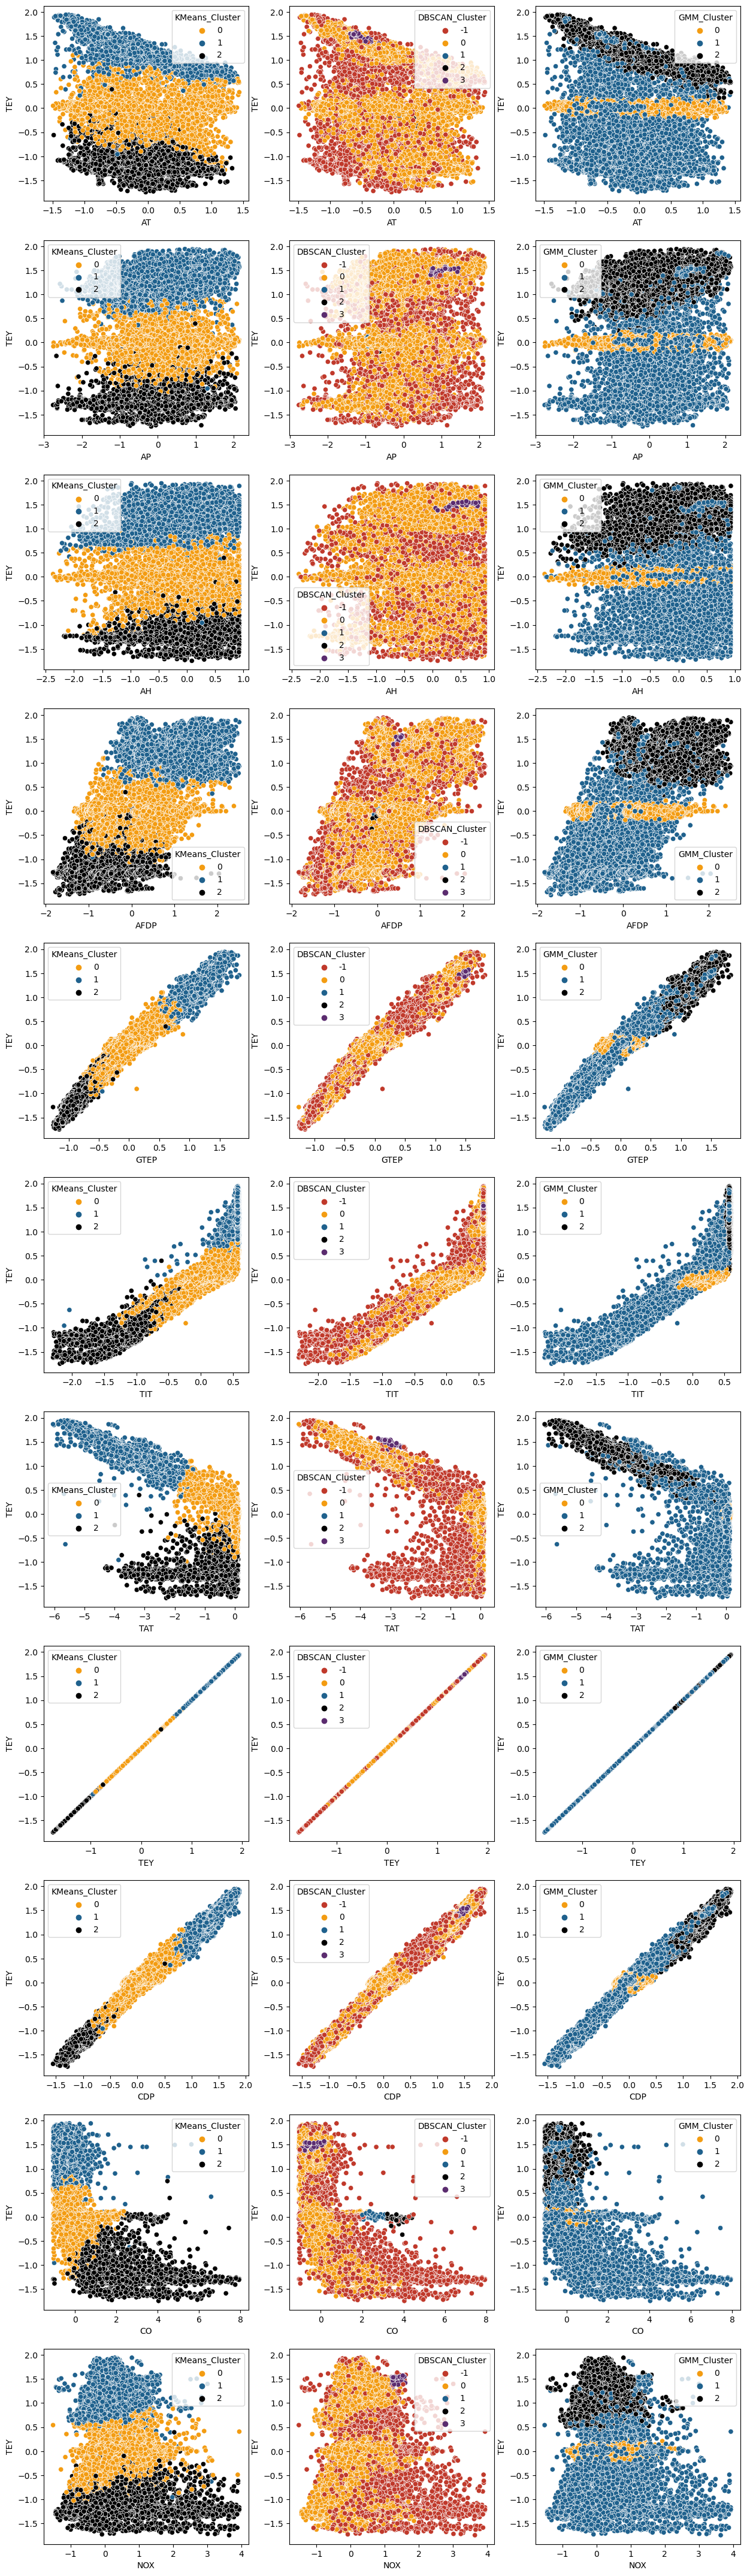

In [33]:
# all the plots show that change of data point with respect to TEY feature
# because TEY is used here as expected output feature
plt.figure(figsize=(15,55))
for i,j in enumerate(transformed_data.columns[0:11]):
    
    # KMeans_Cluster
    plt.subplot(11,3, 3*i+1)
    sns.scatterplot(transformed_data, 
                    x=j, 
                    y='TEY', hue='KMeans_Cluster', 
                    palette={-1:noise, 0:cluster0, 1:cluster1, 2:cluster2, 3:cluster3, 4:cluster4, 5:cluster5, 6:cluster6})

    # DBSCAN_Cluster
    plt.subplot(11,3, 3*i+2)
    sns.scatterplot(transformed_data, 
                    x=j, 
                    y='TEY', hue='DBSCAN_Cluster', 
                    palette={-1:noise, 0:cluster0, 1:cluster1, 2:cluster2, 3:cluster3, 4:cluster4, 5:cluster5, 6:cluster6})

    # GMM_Cluster
    plt.subplot(11,3, 3*i+3)
    sns.scatterplot(transformed_data, 
                    x=j, 
                    y='TEY', hue='GMM_Cluster', 
                    palette={-1:noise, 0:cluster0, 1:cluster1, 2:cluster2, 3:cluster3, 4:cluster4, 5:cluster5, 6:cluster6})

<Axes: ylabel='TEY'>

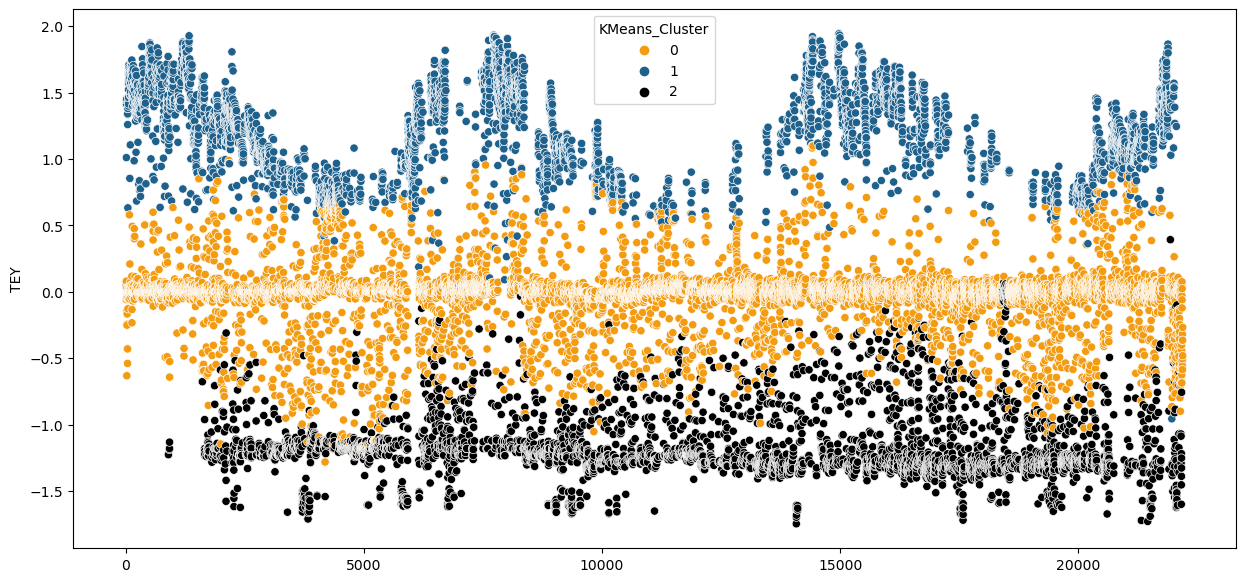

In [34]:
# KMeans_Cluster clustering on TEY feature
plt.figure(figsize=(15,7))
sns.scatterplot(transformed_data, 
                x=transformed_data.index, 
                y='TEY', hue='KMeans_Cluster', 
                palette={-1:noise, 0:cluster0, 1:cluster1, 2:cluster2, 3:cluster3, 4:cluster4, 5:cluster5, 6:cluster6})

<Axes: ylabel='TEY'>

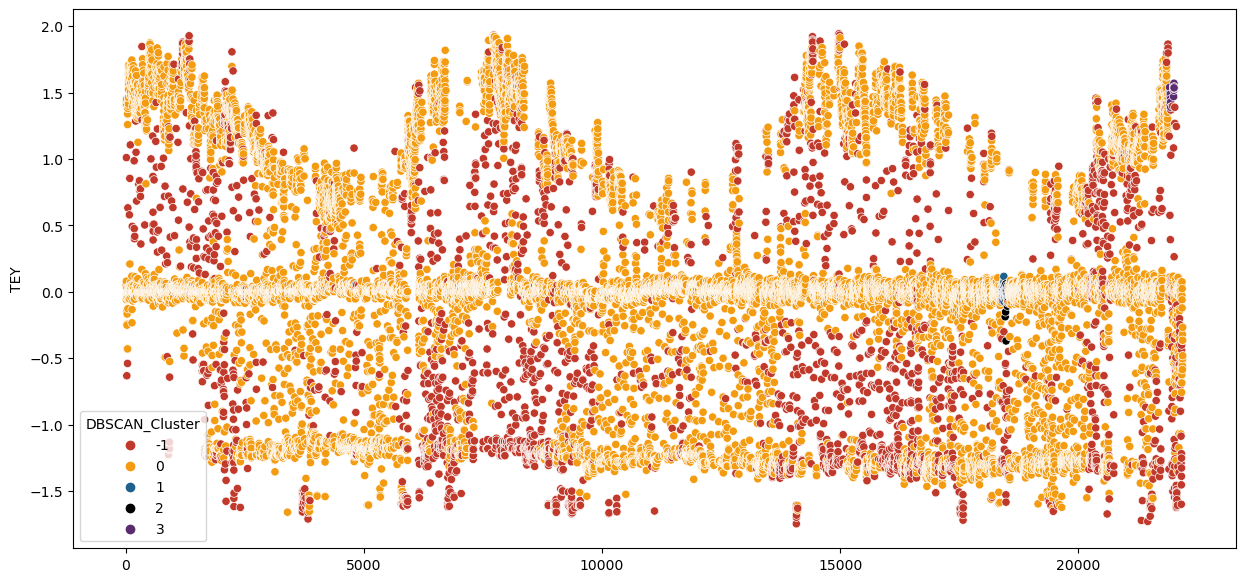

In [35]:
# DBSCAN_Cluster clustering on TEY feature
plt.figure(figsize=(15,7))
sns.scatterplot(transformed_data, 
                x=transformed_data.index, 
                y='TEY', hue='DBSCAN_Cluster', 
                palette={-1:noise, 0:cluster0, 1:cluster1, 2:cluster2, 3:cluster3, 4:cluster4, 5:cluster5, 6:cluster6})

<Axes: ylabel='TEY'>

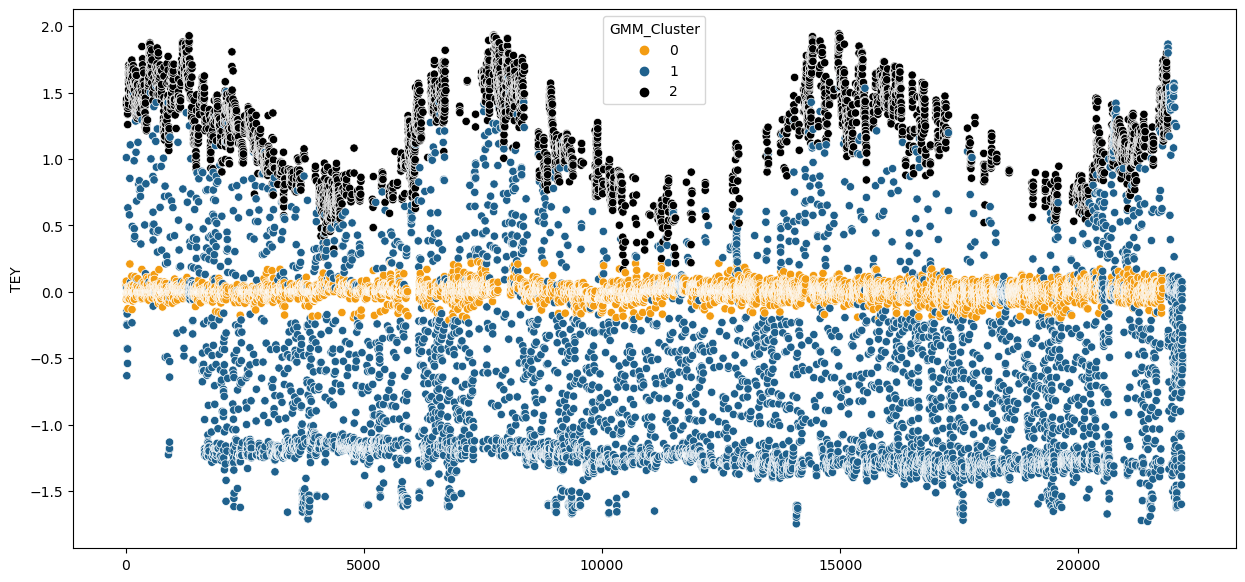

In [36]:
# GMM_Cluster clustering on TEY feature
plt.figure(figsize=(15,7))
sns.scatterplot(transformed_data, 
                x=transformed_data.index, 
                y='TEY', hue='GMM_Cluster', 
                palette={0:cluster0, 1:cluster1, 2:cluster2, 3:cluster3, 4:cluster4, 5:cluster5, 6:cluster6})

<a id='conclusion_section'></a>
## 3. Conclusion

In this project, 3 most popular **Unsupervised Clustering Machine Learning Algorithms** are applied to the **robust scaled dataset**. As a result of these algorithms might be summarized as follows;

- **K-Mean**s: This is the best performed method on the *robust scaled dataset*. Since, the dataset is prone to be represented by the spherical clusters and this situation leads to the KMeans model capture the clusters better than others. Also, this method performed better than other methods for *Silhouette Score*, *Davies-Bouldin Index* and *Calinski-Harabasz Index* evaluation merics.
- **DBSCAN**: This is the worst performed method on the *robust scaled dataset*. Since, all the data points are scattered with similar density points around the entire dataset for most of the features. THis situation leads to mis-clustering and clustering as a noise by the DBSCAN.
- **GaussianMixtureModel**: This is the moderately performed method on the *robust scaled dataset*. The model assumes that dataset features have Gaussian distributions and it uses these normally distributed features for clustering. However, some of the features have no normal distributions and the other ones only have similarity to normal distribution. Therefore, model performed moderately.

---